In [35]:
import json
import datetime,time
import pytz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from statistics import mean
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statistics import mean
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

In [2]:
path = "tweet_data/"

files = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", \
        "tweets_#nfl.txt", "tweets_#patriots.txt", \
        "tweets_#sb49.txt", "tweets_#superbowl.txt"]
topics = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]

for i, fl in enumerate(files):
    print("files[" + str(i) + "] => " + fl)

files[0] => tweets_#gohawks.txt
files[1] => tweets_#gopatriots.txt
files[2] => tweets_#nfl.txt
files[3] => tweets_#patriots.txt
files[4] => tweets_#sb49.txt
files[5] => tweets_#superbowl.txt


In [42]:
def generate_df(pddata_raw):
    """
    Create a new dataframe with desired form
    """
    df = pd.DataFrame([],columns=['time unit','tweets','retweets','followers sum','followers max','time'])
    
    col = pddata_raw.columns.get_loc('time')
    df['time unit'] = range(int(pddata_raw.iloc[len(pddata_raw.index)-1,col] - pddata_raw.iloc[0,col]+1))
    df['tweets'] = pddata_raw.groupby("time")['tweets'].sum()
    df['retweets'] = pddata_raw.groupby("time")['retweets'].sum()
    df['followers sum'] = pddata_raw.groupby("time")['followers'].sum()
    df['followers max'] = pddata_raw.groupby("time")["followers"].max()
    df['time'] = pddata_raw.groupby("time")['time'].mean()        
    # reset index of df
    df = df.fillna(0).reset_index(drop=True)
    
    return df

In [47]:

def parse_dataset(path,files):
    """
    Parse x conponent of the dataset into pandas DataFrame including columns of:
    tweets, retweets, total_followers, max_followers, mentioned, media, active, author, favourites_count, title
    with lines of hours,
    where mentioned: number of @ in tweets per hour
          media: number of url in tweets per hour
          active: a measure of active state of author
          author: number of unique authors post tweet per hour
          favourites_count: the total number of likes by this user
          title: length of this tweet's title
    Parse y of dataset as number of tweets in the next hour.
    """
    start_time = time.mktime(time.strptime("2015-02-01 08:00:00",'%Y-%m-%d %H:%M:%S'))
    end_time = time.mktime(time.strptime("2015-02-01 20:00:00",'%Y-%m-%d %H:%M:%S'))   

    start_hour_idx = ((2-1)*31+1-14)*24+8
    end_hour_idx = ((2-1)*31+1-14)*24+20
    start_minute_idx = (((2-1)*31+1-14)*24 + (8-0))*12 + 0//5    
        
    # extract raw features
    data_raw = [[],[],[]]
    for file in files:
        for line in open(path + file, 'r', encoding="utf-8") :
            row_tmp = []
            a = json.loads(line)
            citation_date = a['citation_date']
            tweet = 1
            retweet = a['metrics']['citations']['total']
            foll = a['author']['followers']  

            # append to row_tmp
            row_tmp.append(citation_date)        
            row_tmp.append(tweet)        
            row_tmp.append(retweet)
            row_tmp.append(foll)  
            # assign to 3 periods
            if citation_date < start_time:
                data_raw[0].append(row_tmp)
            elif citation_date < end_time:
                data_raw[1].append(row_tmp)
            else:
                data_raw[2].append(row_tmp)            

    # generate raw pandas dataframe
    pddata_raw_1 = transfer_time(data_raw[0],'hour')
    pddata_raw_1['time'] = pddata_raw_1['time'] - pddata_raw_1.loc[0,'time']
    
    pddata_raw_2 = transfer_time(data_raw[1],'minute')
#     pddata_raw_2['time'] = pddata_raw_2['time'] - start_minute_idx
    pddata_raw_2['time'] = pddata_raw_2['time'] - pddata_raw_2.loc[0,'time']

    pddata_raw_3 = transfer_time(data_raw[2],'hour')
#     pddata_raw_3['time'] = pddata_raw_3['time'] - end_hour_idx - 1    
    pddata_raw_3['time'] = pddata_raw_3['time'] - pddata_raw_3.loc[0,'time']
    print('1',pddata_raw_1)
    
    # generate df and df_y for each time slot
    df_1 = generate_df(pddata_raw_1)  
    df_y_1 = df_1.iloc[1:,1].reset_index(drop=True)
    df_1 = df_1[:len(df_y_1)]
    print('2',df_1)
    
    df_2 = generate_df(pddata_raw_2)
    df_y_2 = df_2.iloc[1:,1].reset_index(drop=True)
    df_2 = df_2[:len(df_y_2)]
   
    df_3 = generate_df(pddata_raw_3)
    df_y_3 = df_3.iloc[1:,1].reset_index(drop=True)
    df_3 = df_3[:len(df_y_3)]
    
    return (df_1.iloc[:,1:],df_y_1), (df_2.iloc[:,1:],df_y_2), (df_3.iloc[:,1:],df_y_3)

In [43]:
def transfer_time(data_raw,time_type):
    
    pst_tz = pytz.timezone('America/Los_Angeles')
    
    # sort according to time
    pddata_raw = pd.DataFrame(data_raw,columns=['time','tweets','retweets','followers'])
    pddata_raw = pddata_raw.sort_values(by = 'time')
    pddata_raw = pddata_raw.reset_index(drop=True)               

    # calculate hour index and minute index from time
    if time_type == 'hour':
        hour_accu = []
        for index, row in pddata_raw.iterrows():  
            p = datetime.datetime.fromtimestamp(row['time'], pst_tz)  
            hour_accu.append(((p.month-1)*31+p.day-14)*24+p.hour)                             
        pddata_raw['time'] = hour_accu
    elif time_type == 'minute':
        minu_accu = []
        for index, row in pddata_raw.iterrows():  
            p = datetime.datetime.fromtimestamp(row['time'], pst_tz)                    
            minu_accu.append((((p.month-1)*31+p.day-14)*24 + (p.hour-0))*12 + p.minute//5)             
        pddata_raw['time'] = minu_accu    
    else:
        print("Invalid time type")
        
    return pddata_raw

In [58]:
def six_times_window(df,df_y):
    m=df.shape[0]
    df_new= pd.DataFrame(np.zeros((m-4,5)),columns=['tweets','retweets','followers sum','followers max',\
                                  'time'])
    df_y_new= pd.DataFrame(np.zeros((m-4)))
    for i in range(m-4):
        
        for j in range(5):
            df_new.iloc[i,j]=(df.iloc[i,j]+df.iloc[i+1,j]+df.iloc[i+2,j]+df.iloc[i+3,j]+df.iloc[i+4,j])
        j=3
        df_new.iloc[i,3]=np.max([df.iloc[i,j],df.iloc[i+1,j],df.iloc[i+2,j],df.iloc[i+3,j],df.iloc[i+4,j]])
        df_y_new.iloc[i,0]=df_y.iloc[i+4]
    
    return df_new, df_y_new    

In [76]:
def plot_recipe(df_y, pred_y):
    """
    This function plots fitted values vs true values
    """
    plt.figure()
    area = np.pi * (4)**2/4
    plt.scatter(df_y, pred_y, s = area)
    plt.plot([df_y.min(), df_y.max()], [df_y.min(), df_y.max()], 'k--', lw = 1)
    plt.xlabel('true values')
    plt.ylabel('fitted values')
    plt.show()

In [48]:
(dfo,dfo_y),(dfo_2,dfo_y_2),(dfo_3,dfo_y_3) =parse_dataset(path,files)

1         time  tweets  retweets  followers
0          0       1         1      145.0
1          0       1         1     3050.0
2          0       1         3     3457.0
3          0       1         2    10658.0
4          0       1         1      570.0
5          0       1         1      833.0
6          0       1         2       85.0
7          0       1         3      120.0
8          0       1         1      331.0
9          0       1         1      166.0
10         0       1         1      785.0
11         0       1         1     2794.0
12         0       1         1     2693.0
13         0       1         1     1176.0
14         0       1         1     1175.0
15         0       1         1     3853.0
16         0       1         1     3310.0
17         0       1         1      165.0
18         0       1         1      165.0
19         0       1         1      419.0
20         0       1         2       39.0
21         0       1         1       20.0
22         0       1         1  

In [59]:
df, df_y  =six_times_window(dfo,dfo_y)
df_2, df_y_2  =six_times_window(dfo_2,dfo_y_2)
df_3, df_y_3  =six_times_window(dfo_3,dfo_y_3)

In [51]:
test_files_1 =["sample0_period1.txt","sample0_period2.txt","sample0_period3.txt"]
test_files_2 =["sample1_period1.txt","sample1_period2.txt","sample1_period3.txt"]
test_files_3 =["sample2_period1.txt","sample2_period2.txt","sample2_period3.txt"]

In [60]:
(df_test1,df_y_test1),(df_2_test1,df_y_2_test1),(df_3_test1,df_y_3_test1) = parse_dataset(path,test_files_1)
(df_test2,df_y_test2),(df_2_test2,df_y_2_test2),(df_3_test2,df_y_3_test2) = parse_dataset(path,test_files_2)
(df_test3,df_y_test3),(df_2_test3,df_y_2_test3),(df_3_test3,df_y_3_test3) = parse_dataset(path,test_files_3)

1      time  tweets  retweets  followers
0       0       1         1    98191.0
1       0       1         1      158.0
2       0       1         1      370.0
3       0       1         2     6549.0
4       0       1         1      187.0
5       0       1         1     1352.0
6       0       1         1    18722.0
7       0       1         2     1427.0
8       0       1         1      617.0
9       0       1         3      213.0
10      0       1         2      213.0
11      0       1         1     3331.0
12      0       1         1      835.0
13      0       1         1     2073.0
14      0       1         1      157.0
15      0       1         1       19.0
16      0       1         1     1470.0
17      0       1         1      106.0
18      0       1         1      215.0
19      0       1         1      189.0
20      0       1         1      333.0
21      0       1        33    41959.0
22      0       1         4   168371.0
23      0       1         1       63.0
24      0       1      

In [61]:
df_test1, df_y_test1  =six_times_window(df_test1,df_y_test1)
df_2_test1, df_y_2_test1  =six_times_window(df_2_test1,df_y_2_test1)
df_3_test1, df_y_3_test1  =six_times_window(df_3_test1,df_y_3_test1)
df_test2, df_y_test2  =six_times_window(df_test2,df_y_test2)
df_2_test2, df_y_2_test2  =six_times_window(df_2_test2,df_y_2_test2)
df_3_test2, df_y_3_test2  =six_times_window(df_3_test2,df_y_3_test2)
df_test3, df_y_test3  =six_times_window(df_test3,df_y_test3)
df_2_test3, df_y_2_test3  =six_times_window(df_2_test3,df_y_2_test3)
df_3_test3, df_y_3_test3  =six_times_window(df_3_test3,df_y_3_test3)

# RandomForest

In [62]:
reg = RandomForestRegressor(oob_score=True,n_estimators=1800,max_depth=10,min_samples_leaf=1,min_samples_split=2, bootstrap=True,max_features='sqrt',random_state=42)
reg.fit(df,df_y)
pred = reg.predict(df)
pred1=reg.predict(df_test1)
pred2=reg.predict(df_test2)
pred3=reg.predict(df_test3)
print(df_y_test1,df_y_test2,df_y_test3)
print(pred1,pred2,pred3)

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


       0
0  120.0        0
0  846.0       0
0  61.0
[313.44513279] [445.89946864] [302.05164752]


In [63]:
reg = RandomForestRegressor(oob_score=True,n_estimators=1800,max_depth=10,min_samples_leaf=1,min_samples_split=2, bootstrap=True,max_features='sqrt',random_state=42)
reg.fit(df_2,df_y_2)
pred = reg.predict(df_2)
pred1=reg.predict(df_2_test1)
pred2=reg.predict(df_2_test2)
pred3=reg.predict(df_2_test3)
print(df_y_2_test1,df_y_2_test2,df_y_2_test3)
print(pred1,pred2,pred3)

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


        0
0  1123.0        0
0  903.0       0
0  28.0
[4083.03511045] [447.14194444] [480.53444444]


In [64]:
reg = RandomForestRegressor(oob_score=True,n_estimators=1800,max_depth=10,min_samples_leaf=1,min_samples_split=2, bootstrap=True,max_features='sqrt',random_state=42)
reg.fit(df_3,df_y_3)
pred = reg.predict(df_3)
pred1=reg.predict(df_3_test1)
pred2=reg.predict(df_3_test2)
pred3=reg.predict(df_3_test3)
print(df_y_3_test1,df_y_3_test2,df_y_3_test3)
print(pred1,pred2,pred3)

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


      0
0  87.0       0
0  46.0       0
0  43.0
[1963.00261376] [2010.18745635] [2013.08078968]


# GradientBoostingRegressor

In [ ]:
reg = GradientBoostingRegressor(n_estimators=1800,max_depth=10,min_samples_leaf=1,min_samples_split=2, max_features='sqrt',random_state=42)
reg.fit(df,df_y)
pred = reg.predict(df)
pred1=reg.predict(df_test1)
pred2=reg.predict(df_test2)
pred3=reg.predict(df_test3)
print(df_y_test1,df_y_test2,df_y_test3)
print(pred1,pred2,pred3)

In [ ]:
reg = GradientBoostingRegressor(n_estimators=1800,max_depth=10,min_samples_leaf=1,min_samples_split=2, max_features='sqrt',random_state=42)
reg.fit(df_2,df_y_2)
pred = reg.predict(df_2)
pred1=reg.predict(df_2_test1)
pred2=reg.predict(df_2_test2)
pred3=reg.predict(df_2_test3)
print(df_y_2_test1,df_y_2_test2,df_y_2_test3)
print(pred1,pred2,pred3)

In [ ]:
reg = GradientBoostingRegressor(n_estimators=1800,max_depth=10,min_samples_leaf=1,min_samples_split=2, max_features='sqrt',random_state=42)
reg.fit(df_3,df_y_3)
pred = reg.predict(df_3)
pred1=reg.predict(df_3_test1)
pred2=reg.predict(df_3_test2)
pred3=reg.predict(df_3_test3)
print(df_y_3_test1,df_y_3_test2,df_y_3_test3)
print(pred1,pred2,pred3)

# Neural Network

In [75]:
scaler = StandardScaler()
scaler.fit(df)
df_trans=scaler.transform(df)
reg = MLPRegressor(hidden_layer_sizes=(50,600,300,),activation='relu', solver='adam', alpha=1e-5, random_state=42) 
reg.fit(df_trans,df_y)
pred = reg.predict(df_trans)
print("MSE=",mean_squared_error(df_y, pred))
pred1=reg.predict(scaler.transform(df_test1))
pred2=reg.predict(scaler.transform(df_test2))
pred3=reg.predict(scaler.transform(df_test3))
print(df_y_test1,df_y_test2,df_y_test3)
print(pred1,pred2,pred3)

F:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE= 4654979.667617774
       0
0  120.0        0
0  846.0       0
0  61.0
[354.5808791] [475.1309108] [426.36961269]


F:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [77]:
scaler = StandardScaler()
scaler.fit(df_2)
df_2_trans=scaler.transform(df_2)
reg = MLPRegressor(hidden_layer_sizes=(600,600,600,),activation='relu', solver='adam', alpha=1e-5, random_state=42) 
reg.fit(df_2_trans,df_y_2)
pred = reg.predict(df_2_trans)
print("MSE=",mean_squared_error(df_y_2, pred))
pred1=reg.predict(scaler.transform(df_2_test1))
pred2=reg.predict(scaler.transform(df_2_test2))
pred3=reg.predict(scaler.transform(df_2_test3))
print(df_y_2_test1,df_y_2_test2,df_y_2_test3)
print(pred1,pred2,pred3)

F:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE= 34971679.41333595
        0
0  1123.0        0
0  903.0       0
0  28.0
[4126.05657568] [4505.05741753] [5353.98825553]


F:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


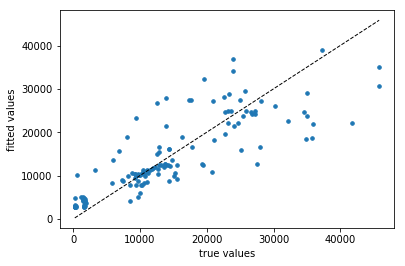

In [78]:
plot_recipe(df_y_2,pred)

In [71]:
scaler = StandardScaler()
scaler.fit(df_3)
df_3_trans=scaler.transform(df_3)
reg = MLPRegressor(hidden_layer_sizes=(40,20,15,),activation='relu', solver='adam', alpha=1e-5, random_state=42) 
reg.fit(df_3_trans,df_y_3)
pred = reg.predict(df_3_trans)
print("MSE=",mean_squared_error(df_y_3, pred))
pred1=reg.predict(scaler.transform(df_3_test1))
pred2=reg.predict(scaler.transform(df_3_test2))
pred3=reg.predict(scaler.transform(df_3_test3))
print(df_y_3_test1,df_y_3_test2,df_y_3_test3)
print(pred1,pred2,pred3)

MSE= 3645394.08023241
      0
0  87.0       0
0  46.0       0
0  43.0
[228.12192698] [193.09509418] [192.79872034]


F:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
